# Time series baseline model for the mosquitoes data 
### Using Exponential Smoothing methods

In [4]:
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

from sklearn.metrics import mean_squared_error
import pandas as pd
import numpy as np

# Import mosquitoes data and check best region to analyze

In [5]:
mosq = pd.read_csv('../Data/ovitrap_data_monthly_province.csv').sort_values(['adm_level', 'date'])
mosq['date'] = pd.to_datetime(mosq.date).dt.date
mosq.head()

,adm_level,date,count_ovi,mean_ovi,error_ovi,error_relative_ovi
7200,Abra,2012-01-01,0.0,NaN,NaN,NaN
7201,Abra,2012-02-01,0.0,NaN,NaN,NaN
7202,Abra,2012-03-01,0.0,NaN,NaN,NaN
7203,Abra,2012-04-01,0.0,NaN,NaN,NaN
7204,Abra,2012-05-01,0.0,NaN,NaN,NaN


In [6]:
#mosq = mosq.loc[mosq.count_ovi>0]
#mosq['count'] = mosq.groupby('adm_level', as_index=False).cumcount('count_ovi')
#print('Maximum number of measurements:', max(mosq.groupby('adm_level', as_index=False).cumcount('count_ovi').values))
#pd.set_option('display.expand_frame_repr', False)
##pd.concat(mosq ,pd.DataFrame(mosq.groupby('adm_level', as_index=False).cumcount('count_ovi')))
#df2 = pd.DataFrame(mosq.groupby('adm_level', as_index=False).cumcount('count_ovi'))
#mosq.append(df2)
#mosq2 = pd.concat([mosq, df2], axis=1)
#mosq2.loc[mosq2[0] == 40]

We will use the region with the most measurements.
(Note: count_ovi is the number of measurements - and thus of ovitraps used - in that month).

In [7]:
mosq.loc[mosq.count_ovi>0].groupby('adm_level', as_index=False).sum().sort_values('count_ovi', ascending=False).head()

,adm_level,count_ovi,mean_ovi,error_ovi,error_relative_ovi
65,Pangasinan,9615.0,1384.900412,195.895837,8.466437
10,Batangas,6632.0,1160.544314,132.908643,7.757148
66,Quezon,6378.0,1104.754133,126.427465,4.009551
64,Pampanga,5146.0,464.914480,91.345518,6.637146
38,Iloilo,5032.0,1619.130424,161.384422,4.790436


In [8]:
df = mosq.loc[(mosq.adm_level == 'Pangasinan')&(mosq.count_ovi>0)].reset_index()

In [9]:
df.rename(mapper={'index':'old_index'}, axis=1, inplace=True)

In [10]:
df.tail()

,old_index,adm_level,date,count_ovi,mean_ovi,error_ovi,error_relative_ovi
52,1406,Pangasinan,2017-03-01,42.0,17.563333,1.827999,0.104080
53,1407,Pangasinan,2017-04-01,1.0,43.750000,0.000000,0.000000
54,1409,Pangasinan,2017-06-01,1.0,34.380000,0.000000,0.000000
55,1411,Pangasinan,2017-08-01,5.0,18.912000,1.834935,0.097025
56,1412,Pangasinan,2017-09-01,3.0,24.073333,1.513240,0.062860


# Checking for neighboring points

To decide where to split out data into train and test sets, we simply look for the first date where a measurement was not made and split the data there if it results in a big enough train set. It turns out that it thus. This way of doing this is of course not necessary, but it's fairly natural.

In [11]:
df['next_month'] = df.old_index + 1

In [12]:
df['next_point'] = pd.concat([df.old_index[1:],pd.Series(df.old_index.iloc[-1] + 1)]).reset_index(drop=True)
df['consecutive'] = df.next_point - df.next_month

Non-zero values in the ```consecutive``` column means that a month was skipped:

In [13]:
df

,old_index,adm_level,date,count_ovi,mean_ovi,error_ovi,error_relative_ovi,next_month,next_point,consecutive
0,1350,Pangasinan,2012-07-01,14.0,39.387857,9.259286,0.235080,1351,1354,3
1,1354,Pangasinan,2012-11-01,7.0,4.925714,2.941088,0.597089,1355,1355,0
2,1355,Pangasinan,2012-12-01,5.0,32.540000,16.331001,0.501875,1356,1356,0
3,1356,Pangasinan,2013-01-01,33.0,28.844848,5.559687,0.192745,1357,1357,0
4,1357,Pangasinan,2013-02-01,9.0,45.836667,11.806748,0.257583,1358,1358,0
5,1358,Pangasinan,2013-03-01,2.0,51.070000,13.385531,0.262102,1359,1359,0
6,1359,Pangasinan,2013-04-01,1.0,0.000000,0.000000,NaN,1360,1360,0
7,1360,Pangasinan,2013-05-01,1.0,0.000000,0.000000,NaN,1361,1361,0
8,1361,Pangasinan,2013-06-01,4.0,3.750000,3.247595,0.866025,1362,1362,0
9,1362,Pangasinan,2013-07-01,9.0,43.791111,16.323253,0.372753,1363,1363,0


In [14]:
consecutive = df.iloc[1:43]

In [15]:
consecutive.shape

(42, 10)

### Visualization

/home/simoes/anaconda3/lib/python3.7/site-packages/pandas/plotting/_matplotlib/converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


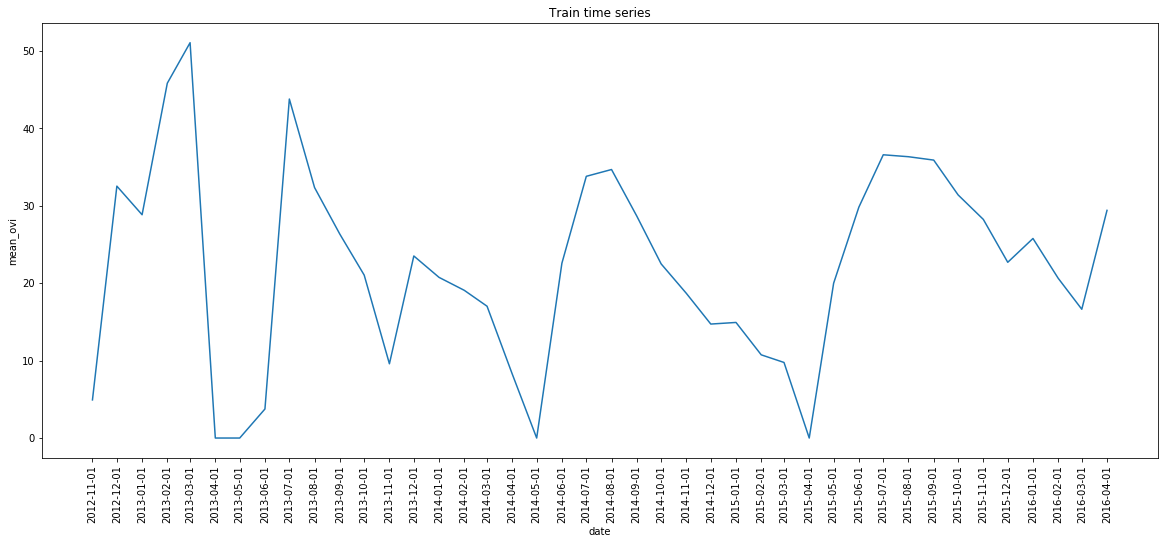

In [16]:
sns.set_context({"figure.figsize": (20, 8)})

dates = consecutive.date
values = consecutive.mean_ovi
plt.figure()
plt.title('Train time series')
sns.lineplot(x=dates, y=values)
plt.xticks(rotation=90)
plt.xticks(dates)
plt.show()

The train set will be the first 42 consecutive data points (excluding the first one of all).
After that there is a break, since there is no valid data point for 2016-05-01.
The test set will be the data points after that breaking point up to 2017-04-01: after that there is another two breaks in the data, and it is not worth it fixing them, since we only lose a couple of points by excluding the points after the first break from the test set.

In [17]:
train = consecutive[['date', 'mean_ovi']]
test = df[43:54][['date', 'mean_ovi']]
train = pd.DataFrame(train, columns=['date','mean_ovi']).set_index('date')
test = pd.DataFrame(test, columns=['date','mean_ovi']).set_index('date')

In [18]:
train.tail()

,mean_ovi
date,
2015-12-01,22.702072
2016-01-01,25.777059
2016-02-01,20.639329
2016-03-01,16.635726
2016-04-01,29.410000


In [19]:
test.head()

,mean_ovi
date,
2016-06-01,38.737222
2016-07-01,37.109107
2016-08-01,35.852651
2016-09-01,29.157500
2016-10-01,27.926964


We can see that 2016-05-01 is missing, as it should.

In [20]:
test.tail()

,mean_ovi
date,
2016-12-01,25.885200
2017-01-01,27.825098
2017-02-01,25.811429
2017-03-01,17.563333
2017-04-01,43.750000


### Add empty row to test.

We need to add an empty row to account for the month that is originally skipped between the train and test sets.

In [21]:
empty = pd.DataFrame()
empty['date'] = pd.Series(['2016-05-01'])
empty['date'] = pd.to_datetime(empty['date']).dt.date
empty['mean_ovi'] = np.nan
empty = pd.DataFrame(empty, columns=['date', 'mean_ovi']).set_index('date')
empty

,mean_ovi
date,
2016-05-01,NaN


In [22]:
test = pd.concat([empty, test])
test

,mean_ovi
date,
2016-05-01,NaN
2016-06-01,38.737222
2016-07-01,37.109107
2016-08-01,35.852651
2016-09-01,29.157500
2016-10-01,27.926964
2016-11-01,25.230541
2016-12-01,25.885200
2017-01-01,27.825098


## Exponential smoothing

In [23]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.holtwinters import Holt

An example to test everything is working as expected:

In [24]:
#model = ExponentialSmoothing(np.asarray(train.mean_ovi+1), trend='add', damped = True, seasonal='add', seasonal_periods=6) #Adding 1 to allow for multiplicative methods
model = ExponentialSmoothing(np.asarray(train.mean_ovi+1), trend='add', damped = True, seasonal='add', seasonal_periods=6) #Adding 1 to allow for multiplicative methods

#fit = model.fit(smoothing_level = 0.9, smoothing_slope = 0.4, damping_slope=0.8) #To visualize the damped model clearly.
fit = model.fit()

In [25]:
fitted = fit.fittedvalues
fcast = fit.forecast(test.shape[0]) 

In [26]:
final = pd.concat([train, test]) #Will use this to extract dates for plots.
final.head()

,mean_ovi
date,
2012-11-01,4.925714
2012-12-01,32.540000
2013-01-01,28.844848
2013-02-01,45.836667
2013-03-01,51.070000


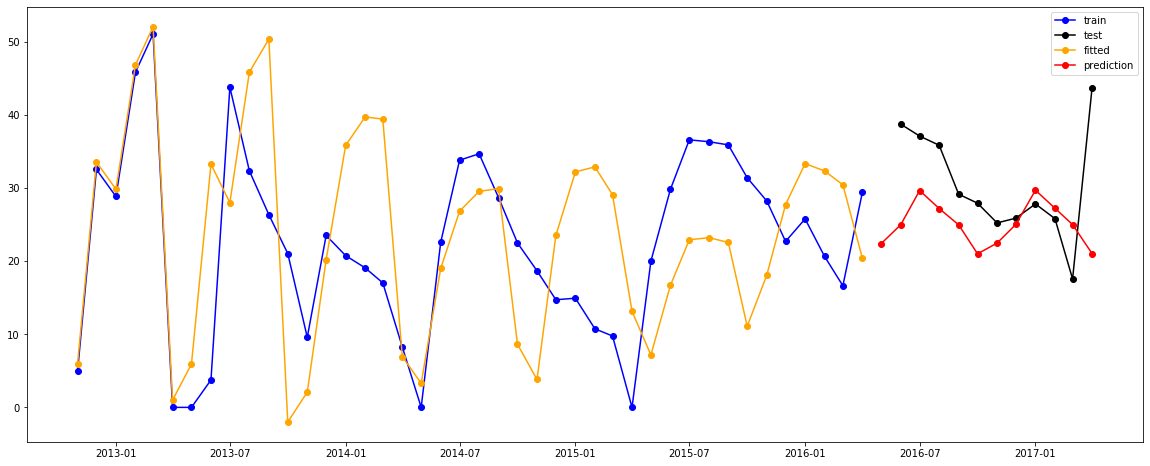

In [27]:
plt.plot(final.index[:train.shape[0]], final.mean_ovi[:train.shape[0]], color = 'blue', label='train', marker = 'o')
plt.plot(final.index[train.shape[0]:], final.mean_ovi[train.shape[0]:], color = 'black', label='test', marker = 'o')
plt.plot(final.index[:train.shape[0]], fitted, color = 'orange', label='fitted', marker = 'o')
plt.plot(final.index[train.shape[0]:], fcast, color = 'red', label='prediction', marker = 'o')
plt.legend()

In [28]:
#RMSE on the test set.
print('RMSE:', np.sqrt(mean_squared_error(fcast[1:], final.mean_ovi[train.shape[0]+1:]))) #[1:] to ignore the Nan.

RMSE: 9.39221952121422


## Grid search over the parameters

In [212]:
#Silence convergence warnings:
import warnings
warnings.filterwarnings(action='ignore')

Incompatible parameters s = None, t = None, d = True  and p = 6. Error message: Can only dampen the trend component


Incompatible parameters s = None, t = None, d = True  and p = 12. Error message: Can only dampen the trend component




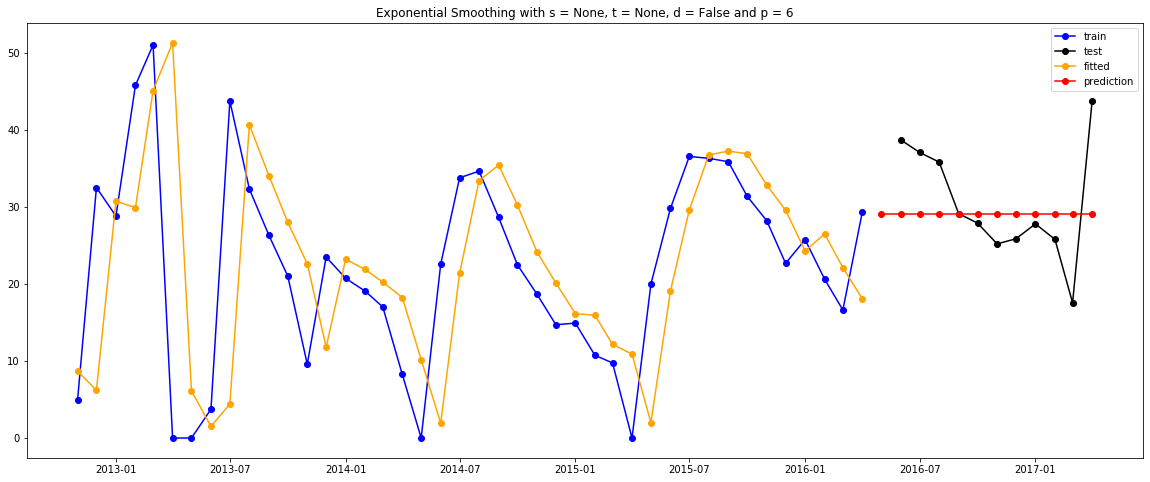

RMSE for s = None, t = None, d = False  and p = 6:   7.308884560069537




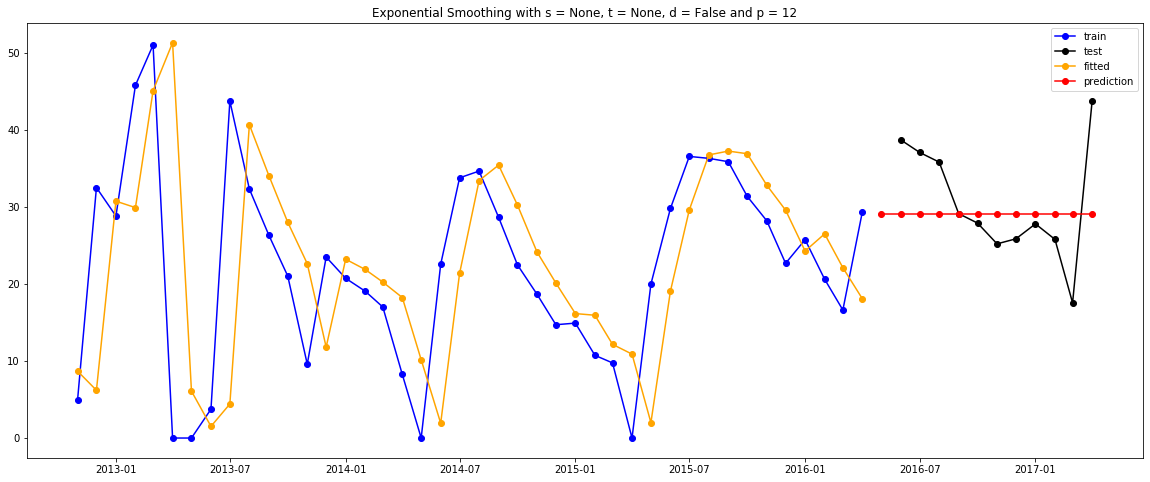

RMSE for s = None, t = None, d = False  and p = 12:   7.308884560069537




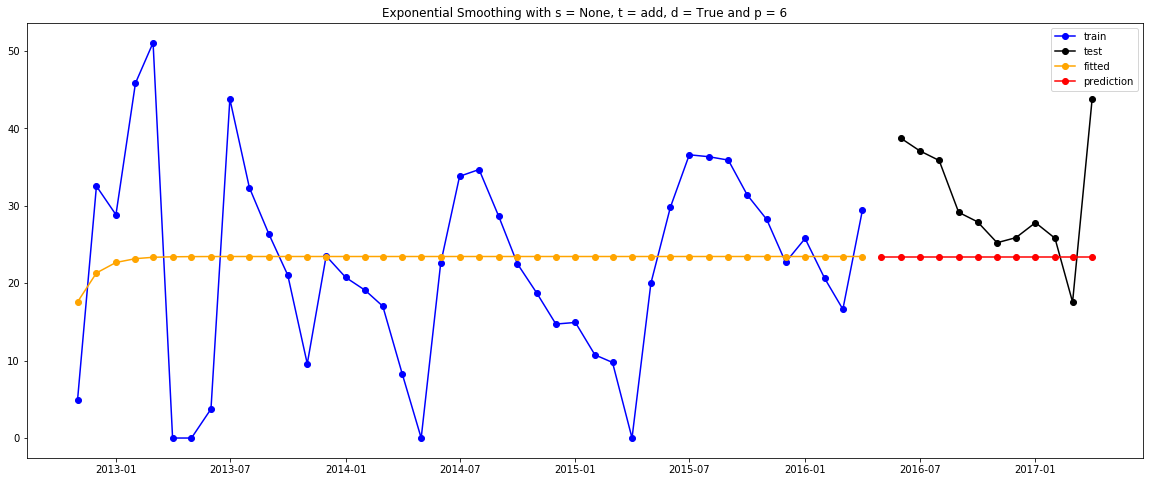

RMSE for s = None, t = add, d = True  and p = 6:   10.033429240232756




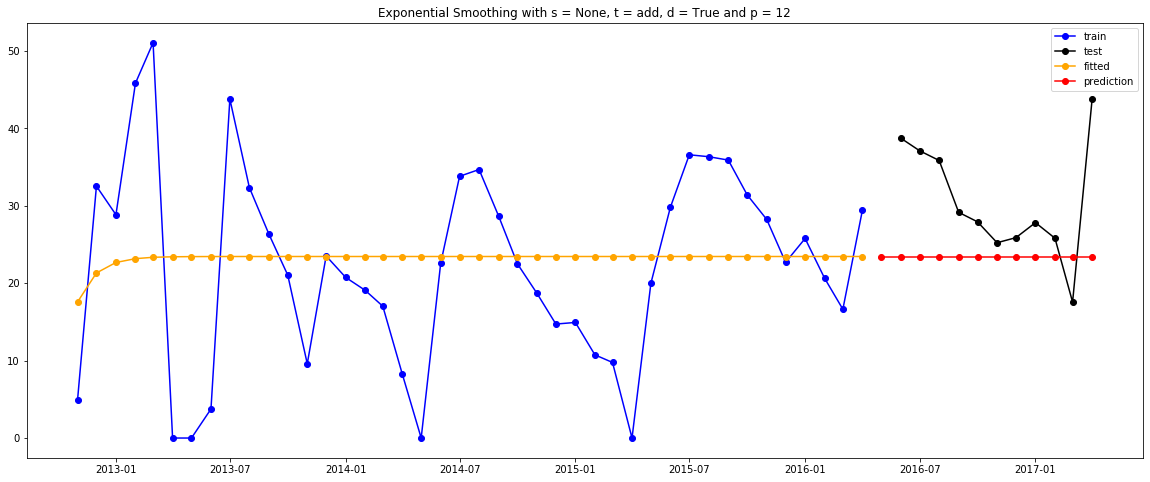

RMSE for s = None, t = add, d = True  and p = 12:   10.033429240232756




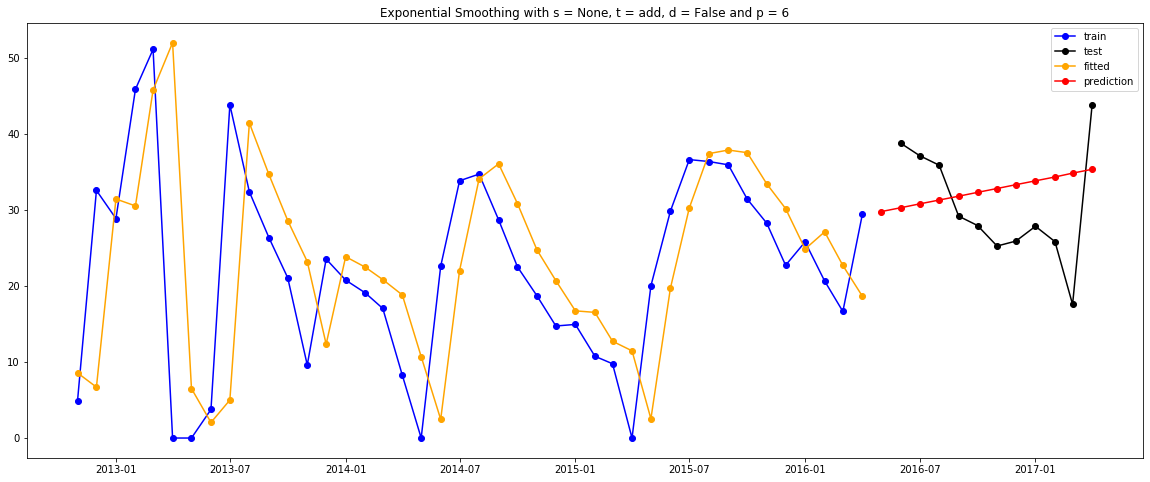

RMSE for s = None, t = add, d = False  and p = 6:   8.242522293177975




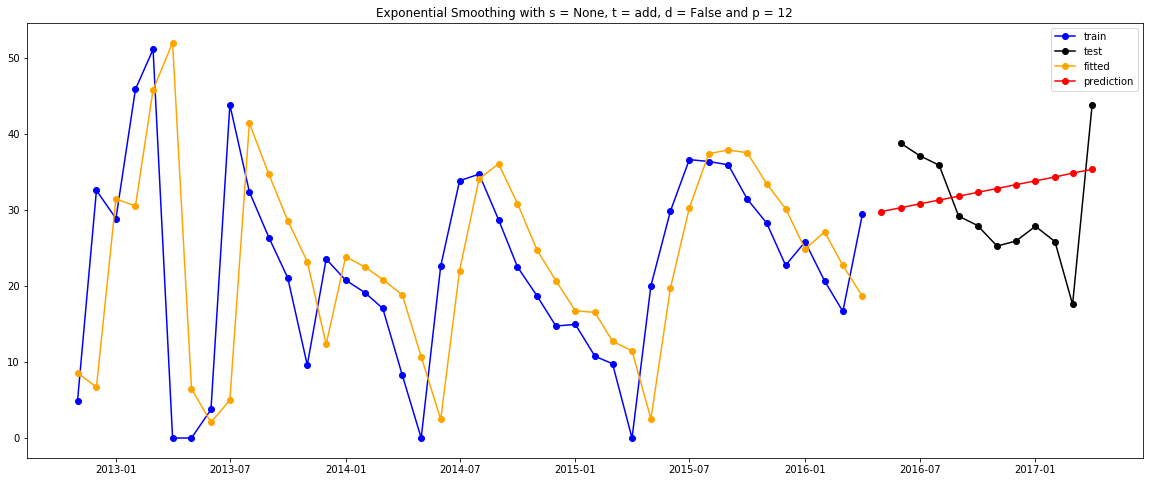

RMSE for s = None, t = add, d = False  and p = 12:   8.242522293177975


RMSE for s = None, t = mul, d = True  and p = 6:   12.020857311438073


RMSE for s = None, t = mul, d = True  and p = 12:   12.020857311438073


RMSE for s = None, t = mul, d = False  and p = 6:   19.555359958513595


RMSE for s = None, t = mul, d = False  and p = 12:   19.555359958513595


Incompatible parameters s = add, t = None, d = True  and p = 6. Error message: Can only dampen the trend component


Incompatible parameters s = add, t = None, d = True  and p = 12. Error message: Can only dampen the trend component




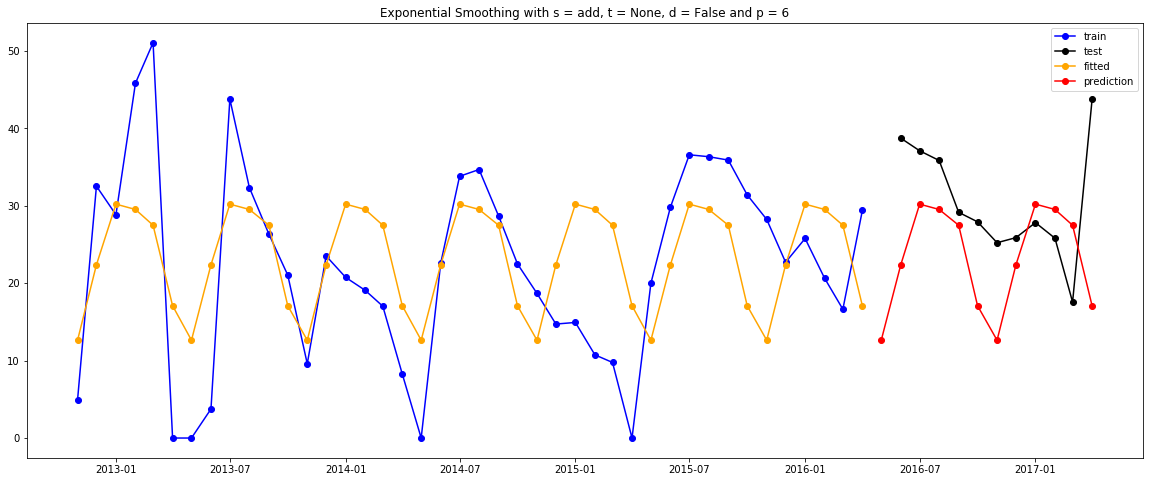

RMSE for s = add, t = None, d = False  and p = 6:   11.581275739851554




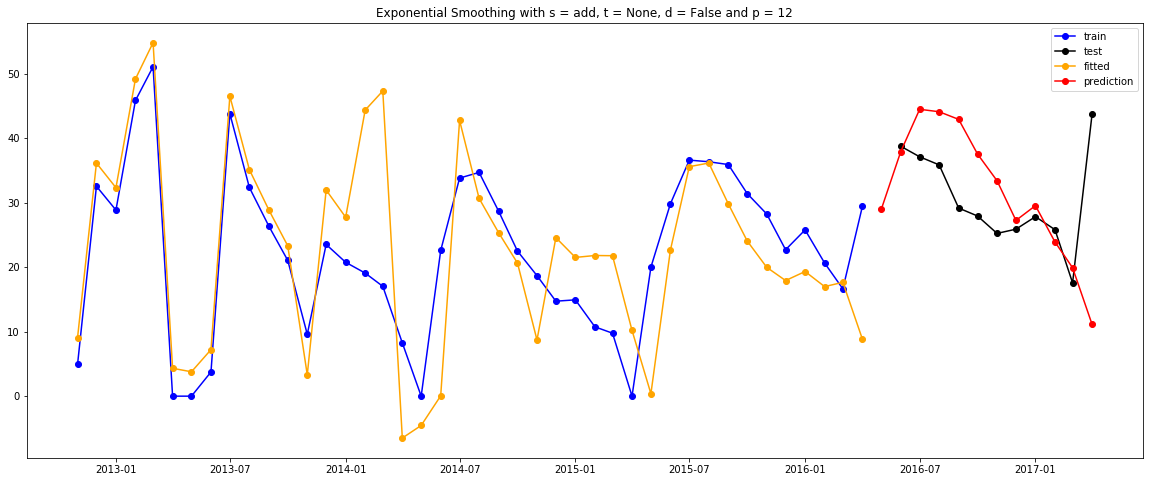

RMSE for s = add, t = None, d = False  and p = 12:   11.867282056792371




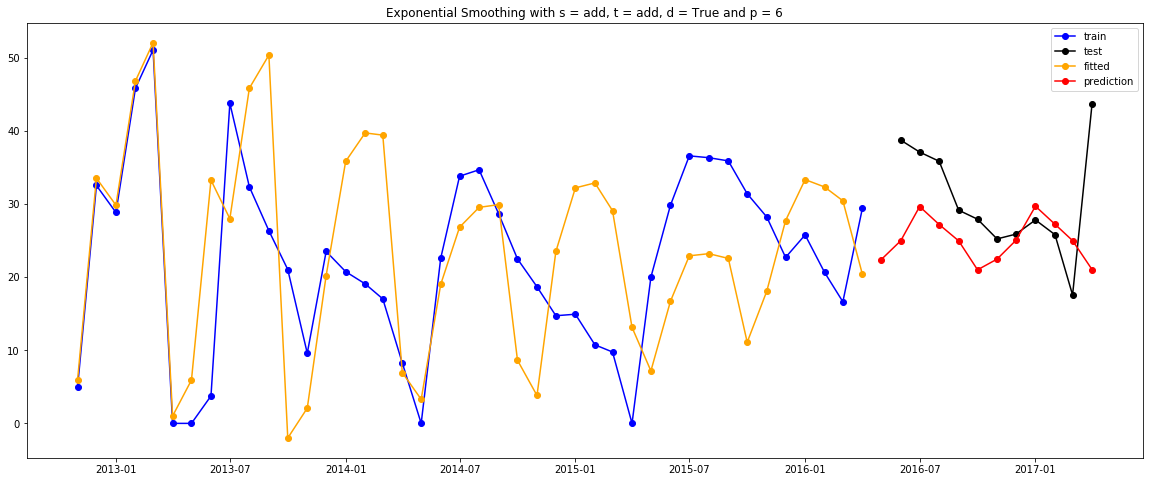

RMSE for s = add, t = add, d = True  and p = 6:   9.39221952121422


RMSE for s = add, t = add, d = True  and p = 12:   12.276683882599727




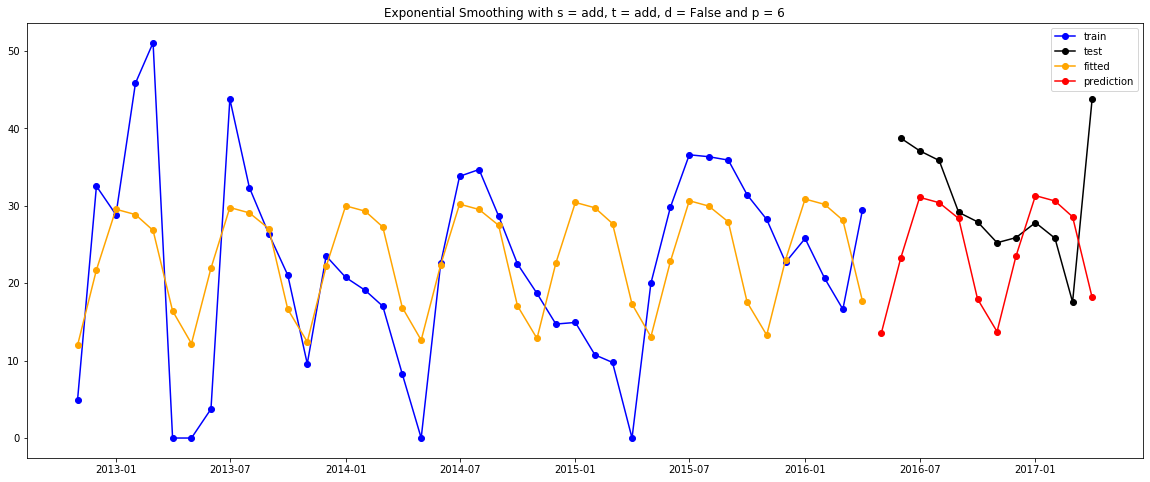

RMSE for s = add, t = add, d = False  and p = 6:   11.094059589206786


RMSE for s = add, t = add, d = False  and p = 12:   13.266012333329392


Incompatible parameters s = add, t = mul, d = True  and p = 6. Error message: Input contains NaN, infinity or a value too large for dtype('float64').


RMSE for s = add, t = mul, d = True  and p = 12:   19.384870253118258


RMSE for s = add, t = mul, d = False  and p = 6:   876324.9426243047


RMSE for s = add, t = mul, d = False  and p = 12:   16.782779513251953


Incompatible parameters s = mul, t = None, d = True  and p = 6. Error message: Can only dampen the trend component


Incompatible parameters s = mul, t = None, d = True  and p = 12. Error message: Can only dampen the trend component




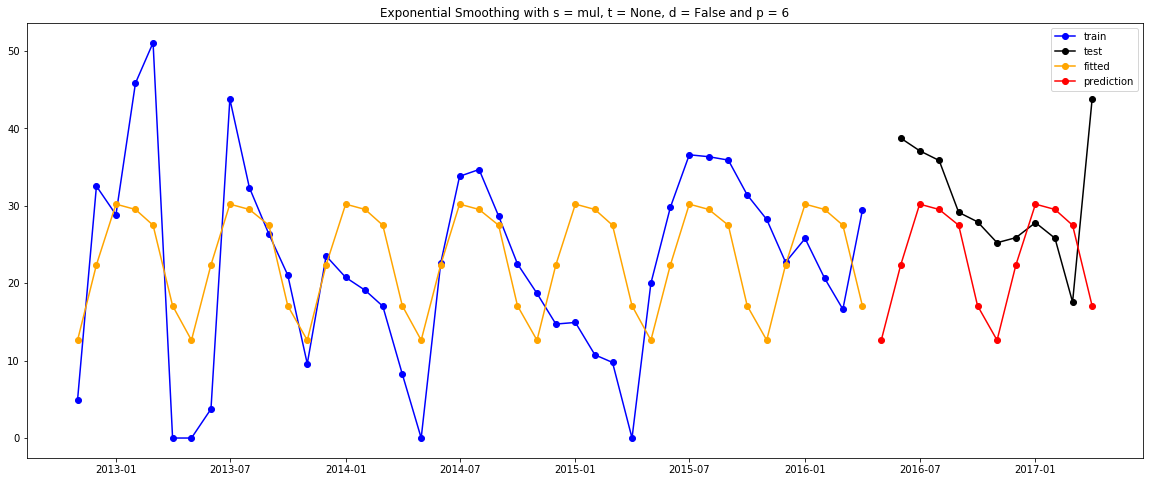

RMSE for s = mul, t = None, d = False  and p = 6:   11.581318599101127


RMSE for s = mul, t = None, d = False  and p = 12:   19.66239458213907


RMSE for s = mul, t = add, d = True  and p = 6:   12.740803593283966


Incompatible parameters s = mul, t = add, d = True  and p = 12. Error message: Input contains NaN, infinity or a value too large for dtype('float64').


RMSE for s = mul, t = add, d = False  and p = 6:   12.7407981670579


RMSE for s = mul, t = add, d = False  and p = 12:   25.065244983920017




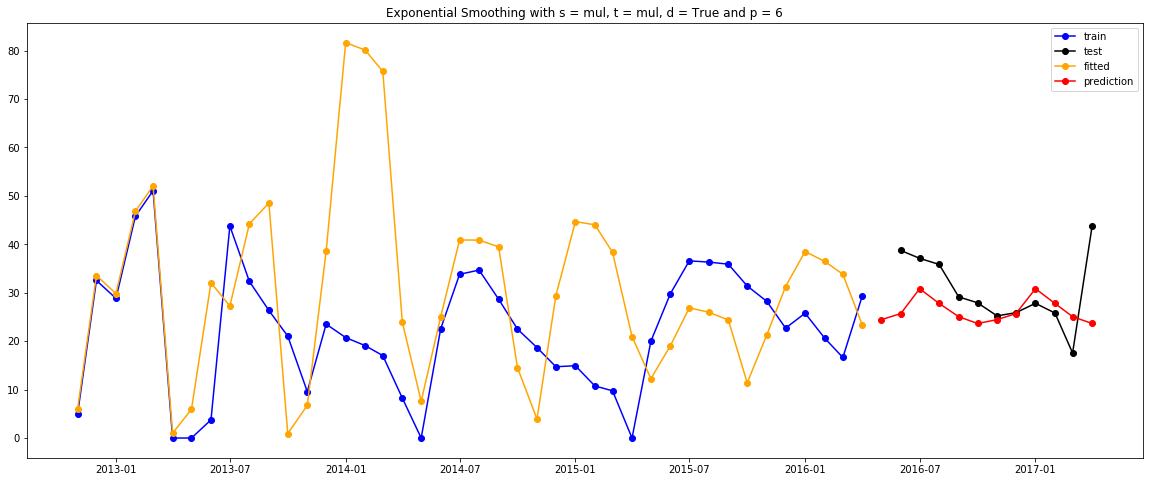

RMSE for s = mul, t = mul, d = True  and p = 6:   8.435976839594751


RMSE for s = mul, t = mul, d = True  and p = 12:   19.68663506480917




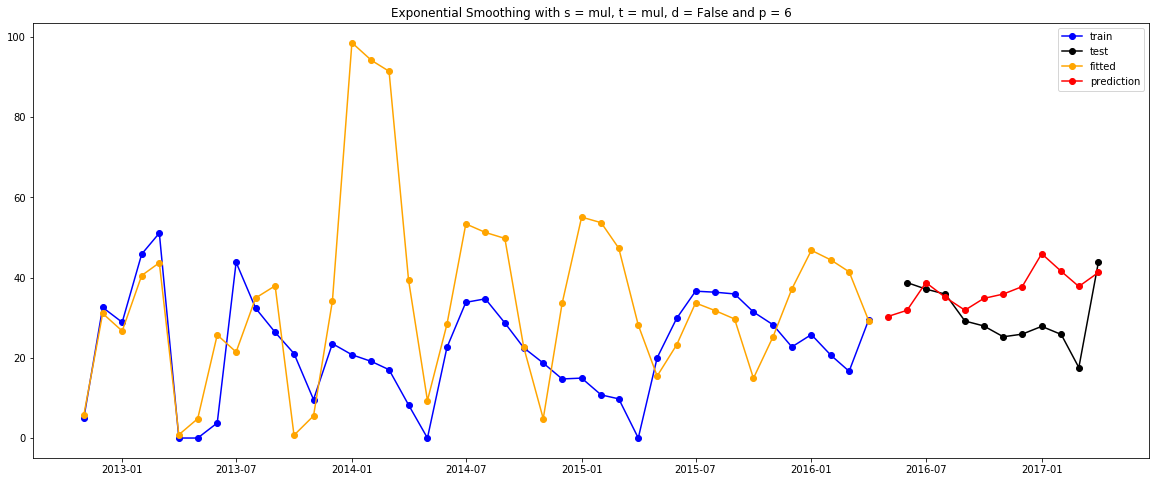

RMSE for s = mul, t = mul, d = False  and p = 6:   11.07292446769988


RMSE for s = mul, t = mul, d = False  and p = 12:   37.943923595897964




In [213]:
s_parameters = [None, 'add', 'mul'] #Seasonality options.
t_parameters = [None, 'add', 'mul'] #Trend options.
d_parameters = [True, False] #Damping option.
p_parameters = [6, 12] #These are the only seasonal periods that are reasonable in this case.
final = pd.concat([train, test]) #This will be useful to extract the dates when plotting.
log = {} #Will contain the parameters and the corresponding RMEs and plots.
plot_max_RMSE = 12 #Max RMSE the forecast can have for plotting (too many bad plots if we don't use this!) 
for s in s_parameters:
    for t in t_parameters:
        for d in d_parameters:
            for p in p_parameters:
                try: #Must use try since some combinations of parameters are nonsensical and raise errors.
                    model = ExponentialSmoothing(np.asarray(train.mean_ovi+1), seasonal=s, trend=t, damped=d, seasonal_periods=p) #Adding 1 to allow for multiplicative methods
                    fit = model.fit()
                    fitted = fit.fittedvalues
                    fcast = fit.forecast(test.shape[0]) 
                    RMSE = np.sqrt(mean_squared_error(fcast[1:], final.mean_ovi[train.shape[0]+1:]))
                    #plot
                    if RMSE <= plot_max_RMSE: #Only plot if RMSE is low enough.
                        fig = plt.figure()
                        plt.title('Exponential Smoothing with s = {}, t = {}, d = {} and p = {}'.format(s, t, d, p))
                        plt.plot(final.index[:train.shape[0]], final.mean_ovi[:train.shape[0]], color = 'blue', label='train', marker = 'o')
                        plt.plot(final.index[train.shape[0]:], final.mean_ovi[train.shape[0]:], color = 'black', label='test', marker = 'o')
                        plt.plot(final.index[:train.shape[0]], fitted, color = 'orange', label='fitted', marker = 'o')
                        plt.plot(final.index[train.shape[0]:], fcast, color = 'red', label='prediction', marker = 'o')
                        plt.legend(); plt.show()
                        log[repr([s, t, d, p])] = [RMSE, fig] #Update log dictionary.
                    #
                    else: #No plot.
                        log[repr([s, t, d, p])] = [RMSE, 'no plot'] #Update log dictionary.
                    print('RMSE for s = {}, t = {}, d = {}  and p = {}:  '.format(s,t,d,p), RMSE) #[1:] to ignore the Nan.
                except ValueError as error_message:
                    print('Incompatible parameters s = {}, t = {}, d = {}  and p = {}. Error message: {}'.format(s,t,d,p,error_message))
                    log[repr([s, t, d, p])] = ['error', 'no plot']
                print('\n ======== \n')

We can easily infer this important fact from these results: our seasonality is not 12: we consistently obtain better results when using p=6 instead.

## The best method:

From the grid search above, we can easily find the best model (the one with the lowest error on the test set):

smallest RMSEs: 7.308884560069537
Best parameters: [[None, None, False, 6], [None, None, False, 12]] 

 Corresponding plots:


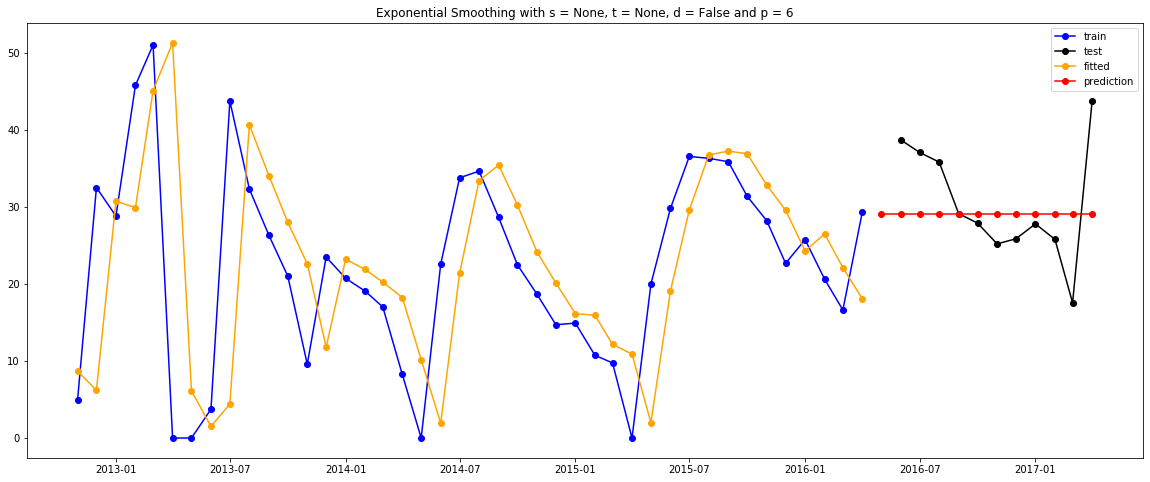

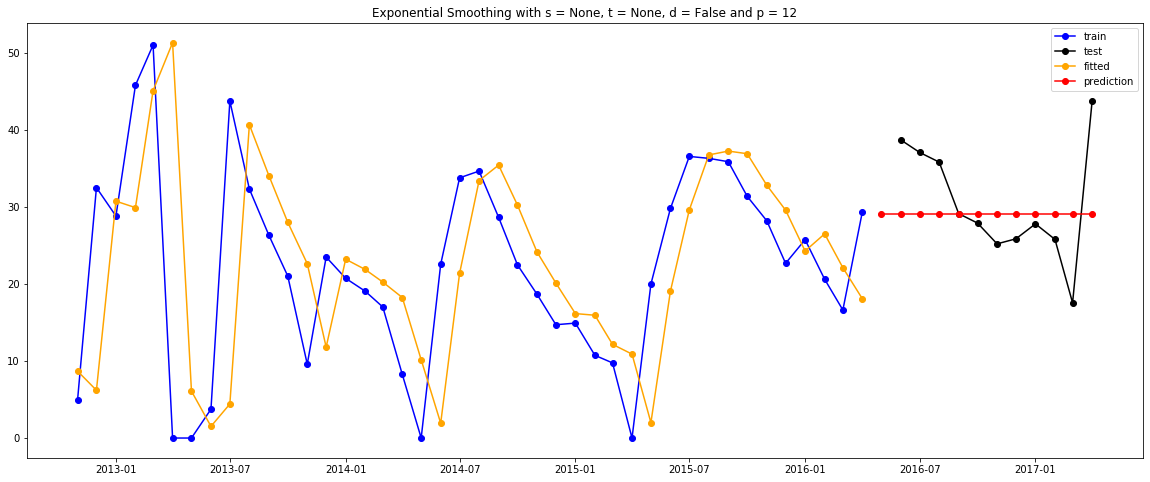

In [214]:
RMSEs = [v[0] for v in list(log.values()) if type(v[0])==np.float64] #Need to select the elements that are floats, since the others are strings and thus min() wouldn't work.
min_RMSE = min(RMSEs)
print('smallest RMSEs:', min_RMSE)

####Show corresponding plot and parameters
#dict_values_with_min_RMSE = [v for v in list(log.values()) if v[0] == min_RMSE]
par_string_list = [key for key, value in log.items() if value[0] == min_RMSE]
parameters_list = [eval(par_string) for par_string in par_string_list]
print('Best parameters:', parameters_list, '\n\n Corresponding plots:')
for [s, t, d, p] in parameters_list: 
    fig = log[repr([s, t, d, p])][1]
    dummy = plt.figure() #Dummy figure to fill with the plot from fig.
    dummy.canvas.manager.canvas.figure = fig
    plt.show()

Of course these two are actually the same method since the value of p has no effect when we are dealing with non-seasonal methods. This repetition is just an artifact of grid search.  
So the best method is the method with no seasonality and no trend, *i.e.* the simple exponential smoothing (SES) method.
This is of course not satisfactory since the SES forecast is flat, and we want to predict spikes in the mosquito population.

## Conclusion:

It is now clear that the seasonality of the data is 6, not 12.  
The best exponential smoothing method is unsatisfying - being a flat line - and has a sqrt deviation of 7.3 (which will turn out to be worse than the Sarimax approach). So we will drop this and build use the Sarimax method as the baseline method.  

Do keep in mind that it was unlikely for us to obtain a successful model this simple time series approach - the population of mosquitoes most certainly depends on many other factors like the weather, which we shall include at a later stage. But first we need a baseline model.